In [6]:
import os 
os.chdir(r"C:\Users\christopher\Desktop\ambulance_perambulation")
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import pandas as pd
# import geopandas as gpd # For loading the map of road segments

In [7]:
# Load the data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


# Minimum Distance Travelled by Ambulance in a Day

Find the optimal position to place 6 ambulances within a day (3 hour interval) in which they will travel the least amount of distance. 

Notes
- Each ambulance is committed every three hours
- Ambulances travel within allocated "sectors"

<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

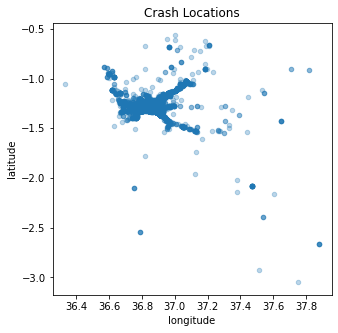

In [9]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(5,5), alpha=0.3, title='Crash Locations')

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

So my first idea , would be to cluster the crash points then find the cluster centroids 
Then place the ambulances in those centres, and see what is the metric of the same 


In [11]:
# View the submission format
ss = pd.read_csv('SampleSubmission (2).csv', parse_dates=['date'])
ss.head(3)

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
def score_ambulance(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [13]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
dates

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 03:00:00',
               '2019-01-01 06:00:00', '2019-01-01 09:00:00',
               '2019-01-01 12:00:00', '2019-01-01 15:00:00',
               '2019-01-01 18:00:00', '2019-01-01 21:00:00',
               '2019-01-02 00:00:00', '2019-01-02 03:00:00',
               ...
               '2019-12-30 21:00:00', '2019-12-31 00:00:00',
               '2019-12-31 03:00:00', '2019-12-31 06:00:00',
               '2019-12-31 09:00:00', '2019-12-31 12:00:00',
               '2019-12-31 15:00:00', '2019-12-31 18:00:00',
               '2019-12-31 21:00:00', '2020-01-01 00:00:00'],
              dtype='datetime64[ns]', length=2921, freq='3H')

### Clustering

In [14]:
# clustering

K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

In [35]:
df['idx'] = 1
df_3hours = df.resample('3H', on='datetime')['idx'].count().reset_index()
df_3hours['datetime'] = df_3hours['datetime'].dt.hour

df_3hours = df_3hours.groupby('datetime').sum().reset_index()
df_pd_3hours = pd.DataFrame(df_3hours)
df_pd_3hours.head()

,datetime,idx
0,0,296
1,3,340
2,6,1724
3,9,976
4,12,834


<AxesSubplot:xlabel='datetime', ylabel='idx'>

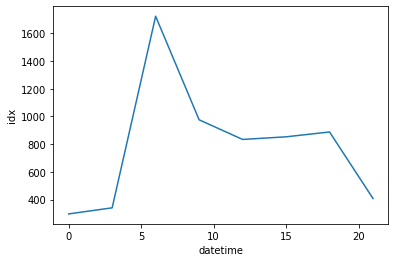

In [39]:
x_3hours = df_pd_3hours['datetime']
y_3hours = df_pd_3hours['idx']
import seaborn as sns 
sns.lineplot(x_3hours,y_3hours,data=df_pd_3hours)

In [45]:
# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]

Clusters=[]
for three_hour_interval in x_3hours.to_list():
    kmeans = KMeans(n_clusters = 6, init ='k-means++')
    kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
    X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    Clusters.append(centers)
    labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point


In [254]:
Clusters[1:3]

[array([[-1.21210609, 36.90659738],
        [-1.23341291, 36.72111074],
        [-2.26993277, 37.38589229],
        [-1.30148658, 36.83909135],
        [-1.44781943, 37.04055723],
        [-1.02141628, 37.06162761]]), array([[-1.23507963, 36.72530534],
        [-1.4837607 , 37.06873142],
        [-0.9852835 , 37.08153029],
        [-2.29821377, 37.46598632],
        [-1.20513955, 36.91417129],
        [-1.30373176, 36.84260687]])]

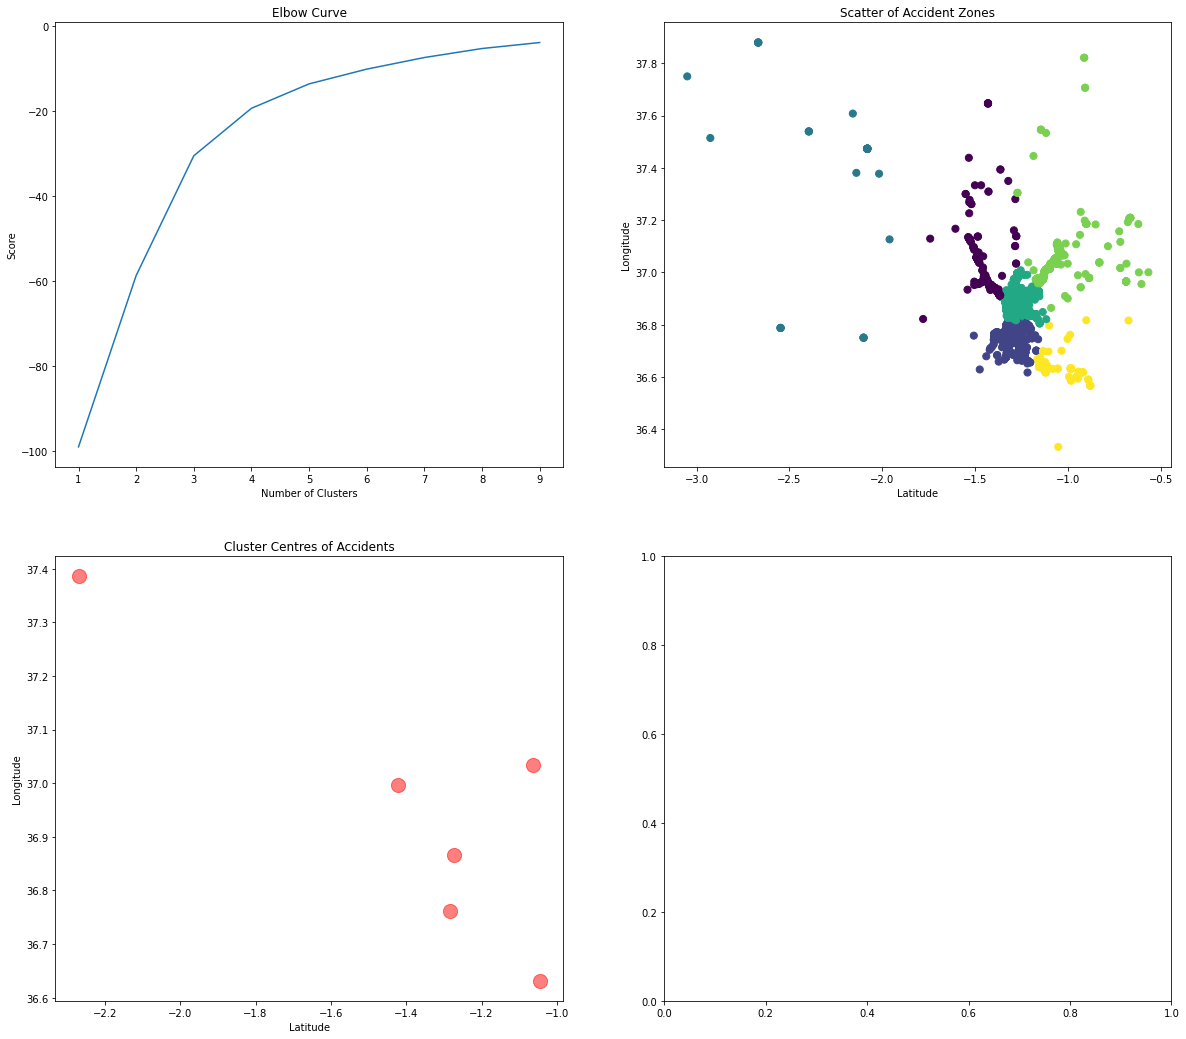

In [17]:

fig, axs = plt.subplots(2, 2,figsize=(20, 18))
axs[0, 0].plot(K_clusters, score)
axs[0, 0].set_title('Elbow Curve')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Number of Clusters')

axs[1,0].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5,cmap='viridis')
axs[1, 0].set_title('Cluster Centres of Accidents')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')

axs[0,1].scatter(x = X['latitude'], y = X['longitude'], c=labels, s=50, cmap='viridis')
axs[0, 1].set_title('Scatter of Accident Zones')
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

points = pd.DataFrame([centers[:, 0], centers[:, 1]]).transpose()

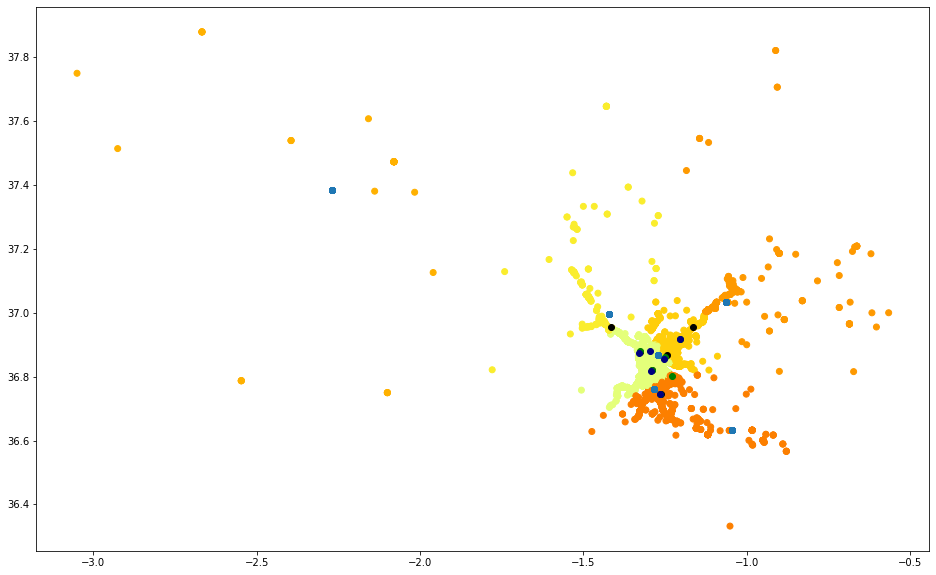

In [248]:
# points.index.name='cluster_label'
# points.reset_index(inplace=True)

# result=pd.merge(X,points,
#                how='left')
plt.figure(figsize=(16, 10))
plt.scatter(result['latitude'],result['longitude'],c=result['cluster_label'],cmap='Wistia')
plt.scatter(result[0],result[1])
plt.scatter(sgd_centres['lat'],sgd_centres['long'],c='black')
plt.scatter(sgd_centres_3['lat'],sgd_centres_3['long'],c='green')
plt.scatter(sgd_centres_4['lat'],sgd_centres_['long'],c='green')

In [ ]:
df_3hours = df.resample('3H', on='datetime')['idx'].count().reset_index()
df_3hours['datetime'] = df_3hours['datetime'].dt.hour

df_3hours = df_3hours.groupby('datetime').sum().reset_index()
df_pd_3hours = pd.DataFrame(df_3hours)

In [110]:
submission = pd.DataFrame({
    'date':dates
})
submission['idx'] = 1
submission_3_hrs=submission.resample('3H', on='date')['idx'].count().reset_index()
submission_3_hrs['dates'] = submission_3_hrs['date'].dt.hour

submission_3_hrs = submission_3_hrs.groupby('date').sum().reset_index()
submission_3_hrs_pd = pd.DataFrame(submission_3_hrs)
submission_3_hrs_pd.shape

(2921, 3)

In [249]:

# Create submission dataframe
submission = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    submission['A'+str(ambulance)+'_Latitude'] = sgd_centres_4.iloc[ambulance][0]
    submission['A'+str(ambulance)+'_Longitude'] = sgd_centres_4.iloc[ambulance][1]
submission.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.291434,36.81916,-1.253096,36.854958,-1.264477,36.74642,-1.295695,36.881577,-1.331068,36.87455,-1.204327,36.916477
1,2019-01-01 03:00:00,-1.291434,36.81916,-1.253096,36.854958,-1.264477,36.74642,-1.295695,36.881577,-1.331068,36.87455,-1.204327,36.916477
2,2019-01-01 06:00:00,-1.291434,36.81916,-1.253096,36.854958,-1.264477,36.74642,-1.295695,36.881577,-1.331068,36.87455,-1.204327,36.916477
3,2019-01-01 09:00:00,-1.291434,36.81916,-1.253096,36.854958,-1.264477,36.74642,-1.295695,36.881577,-1.331068,36.87455,-1.204327,36.916477
4,2019-01-01 12:00:00,-1.291434,36.81916,-1.253096,36.854958,-1.264477,36.74642,-1.295695,36.881577,-1.331068,36.87455,-1.204327,36.916477


In [224]:
sub=submission_3_hrs_pd.copy()
submission_3_hrs_pd.head()

,date,idx,dates
0,2019-01-01 00:00:00,1,0
1,2019-01-01 03:00:00,1,3
2,2019-01-01 06:00:00,1,6
3,2019-01-01 09:00:00,1,9
4,2019-01-01 12:00:00,1,12


In [250]:
score_ambulance(submission, reference)

103.12131392776514

In [251]:
submission.to_csv('submission_12.csv',index=False)

In [157]:
Clusters[0]

array([[-1.02141628, 37.06162761],
       [-1.30331185, 36.84114893],
       [-2.26993277, 37.38589229],
       [-1.23364318, 36.72134521],
       [-1.21205756, 36.90660569],
       [-1.46577455, 37.07494571]])

In [220]:
sub.shape

(2921, 13)

In [259]:
for i in range(2921):
    for ambulance in range(6):
        if sub.dates[i]==0:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[4].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[4].tolist()[ambulance][1]
        elif sub.dates[i]==3:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[1].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[1].tolist()[ambulance][1]
        elif sub.dates[i]==6:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[2].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[2].tolist()[ambulance][1]
        elif sub.dates[i]==9:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[3].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[3].tolist()[ambulance][1]
        elif sub.dates[i]==12:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[4].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[4].tolist()[ambulance][1]
        elif sub.dates[i]==15:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[5].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[5].tolist()[ambulance][1]
        elif sub.dates[i]==18:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[6].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[6].tolist()[ambulance][1]
        elif sub.dates[i]==21:
            sub['A'+str(ambulance)+'_Latitude'] = Clusters[7].tolist()[ambulance][0]
            sub['A'+str(ambulance)+'_Longitude'] =Clusters[7].tolist()[ambulance][1]

In [ ]:
score_ambulance(submission, reference)

In [ ]:
sub.drop(['dates','idx'],axis=1,inplace=True)
sub.to_csv('submission_5.csv',index=False)